In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("LoanApprovalPrediction").getOrCreate()

# Baca data CSV menggunakan Spark
data = spark.read.csv("LoanApprovalPrediction.csv", header=True, inferSchema=True)

# Tampilkan skema data
data.printSchema()

# Tampilkan beberapa baris pertama data
data.show()

# Sekarang Anda dapat melakukan analisis data menggunakan Spark DataFrame

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+------------

In [3]:
# Menampilkan beberapa baris pertama dari DataFrame
data.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      NULL|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [4]:
from pyspark.sql.functions import col

# Hitung jumlah variabel kategorikal
categorical_variables_count = data.select(*[col(column).cast("string") for column, dtype in data.dtypes if dtype == "object"]).count()
print("Categorical variables:", categorical_variables_count)

Categorical variables: 598


In [5]:
from pyspark.sql.functions import col

# Menghapus kolom 'Loan_ID'
data = data.drop("Loan_ID")

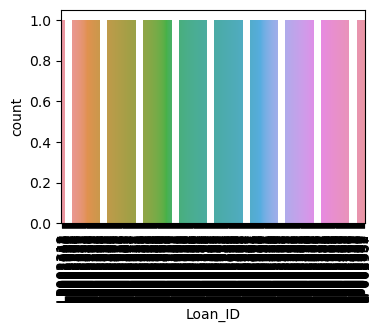

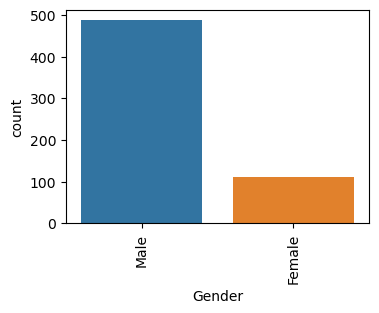

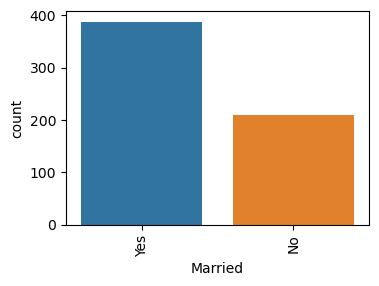

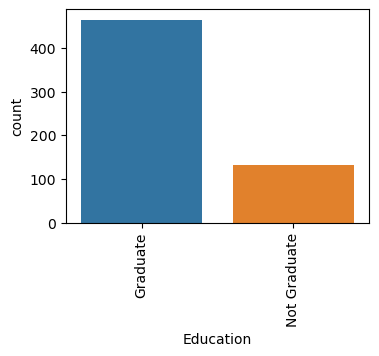

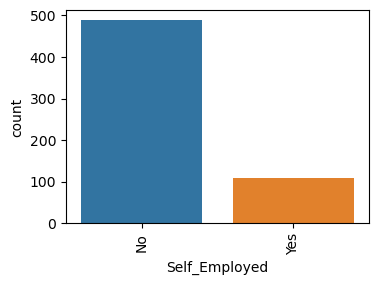

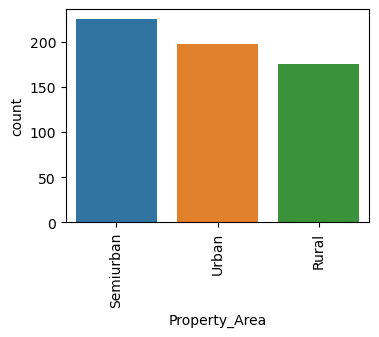

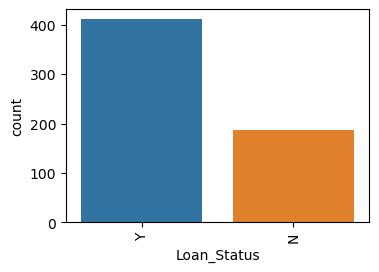

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("LoanApprovalAnalysis").getOrCreate()

# Membaca data CSV
data = spark.read.csv("LoanApprovalPrediction.csv", header=True, inferSchema=True)

# Menghitung variabel kategorikal dan menggabungkannya
object_cols = [col_name for col_name, col_type in data.dtypes if col_type == "string"]

# Mendefinisikan index sebelum loop
index = 1

for col in object_cols:
    cat_counts = data.groupBy(col).count().orderBy("count", ascending=False).toPandas()

    # Membuat plot bar
    plt.figure(figsize=(18, 36))
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=cat_counts[col], y=cat_counts["count"])
    index += 1

# Menampilkan plot
plt.show()

In [7]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Daftar kolom yang merupakan variabel kategorikal
categorical_cols = [col_name for col_name, col_type in data.dtypes if col_type == "string"]

# Inisialisasi sebuah list untuk menampung StringIndexer
indexers = []

# Menggunakan StringIndexer untuk mengkodekan variabel kategorikal
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    indexers.append(indexer)

# Menggabungkan semua StringIndexer ke dalam satu pipeline
pipeline = Pipeline(stages=indexers)

# Fit dan transform data menggunakan pipeline
model = pipeline.fit(data)
data = model.transform(data)

# Hapus kolom asli
data = data.drop(*categorical_cols)

# Rename kolom hasil pengkodean
for col in categorical_cols:
    data = data.withColumnRenamed(col + "_index", col)

# Tampilkan DataFrame yang telah diencode
data.show()

+----------+---------------+-----------------+----------+----------------+--------------+-------+------+-------+---------+-------------+-------------+-----------+
|Dependents|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Loan_ID|Gender|Married|Education|Self_Employed|Property_Area|Loan_Status|
+----------+---------------+-----------------+----------+----------------+--------------+-------+------+-------+---------+-------------+-------------+-----------+
|         0|           5849|              0.0|      NULL|             360|             1|    0.0|   0.0|    1.0|      0.0|          0.0|          1.0|        0.0|
|         1|           4583|           1508.0|       128|             360|             1|    1.0|   0.0|    0.0|      0.0|          0.0|          2.0|        1.0|
|         0|           3000|              0.0|        66|             360|             1|    2.0|   0.0|    0.0|      0.0|          1.0|          1.0|        0.0|
|         0|          

In [8]:
from pyspark.sql.functions import col

# Menghitung jumlah kolom dengan tipe data 'string' (variabel kategorikal)
categorical_variable_count = len([col_name for col_name, col_type in data.dtypes if col_type == "string"])
print("Categorical variables:", categorical_variable_count)

Categorical variables: 0


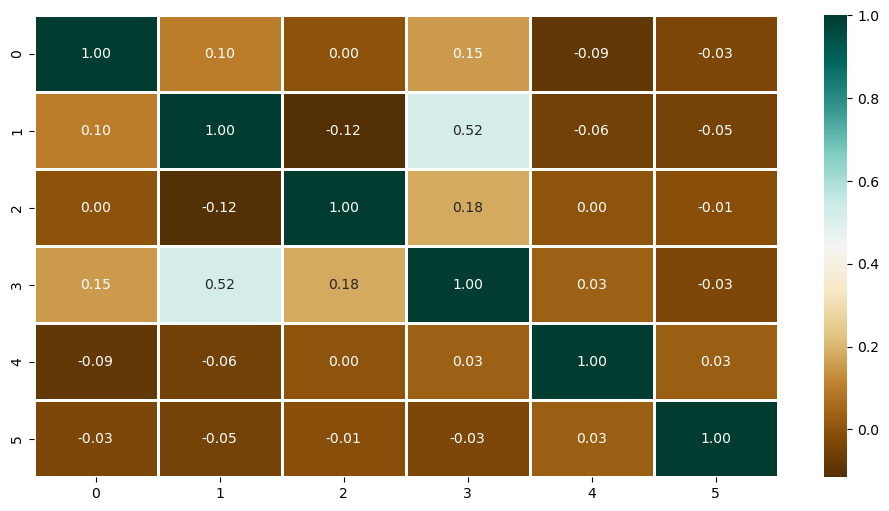

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("LoanApprovalAnalysis").getOrCreate()

# Membaca data CSV
data = spark.read.csv("LoanApprovalPrediction.csv", header=True, inferSchema=True)

# Menggabungkan kolom-kolom numerik menjadi satu kolom vektor
feature_cols = [col_name for col_name, col_type in data.dtypes if col_type == "int" or col_type == "double"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
data = vector_assembler.transform(data)

# Menghitung matriks korelasi
correlation_matrix = Correlation.corr(data, "features").head()

# Mengekstrak matriks korelasi sebagai matriks numpy
correlation_matrix = correlation_matrix[0].toArray()

# Membuat heatmap korelasi
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, cmap="BrBG", fmt=".2f", linewidths=2, annot=True)

# Menampilkan plot
plt.show()

In [2]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("LoanApprovalAnalysis").getOrCreate()

# Membaca data CSV
data = spark.read.csv("LoanApprovalPrediction.csv", header=True, inferSchema=True)

# Menggunakan PySpark SQL untuk menghitung statistik yang diperlukan
result = data.groupBy("Gender", "Married", "Loan_Status").count()

# Konversi DataFrame PySpark ke Pandas
result_pandas = result.toPandas()

# Membuat plot bar menggunakan Seaborn atau Matplotlib
plt.figure(figsize=(8, 6))
sns.barplot(x="Gender", y="count", hue="Loan_Status", data=result_pandas)
plt.show()

NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import isnan, when, count, col

# Initialize a Spark session
spark = SparkSession.builder.appName("LoanApprovalPrediction").getOrCreate()

# Membaca data CSV
data = spark.read.csv("LoanApprovalPrediction.csv", header=True, inferSchema=True)

# Membuat list kolom dengan nilai null
null_columns = [col_name for col_name in data.columns if data.where(data[col_name].isNull()).count() > 0]

# Menggunakan Imputer untuk mengisi nilai null dalam kolom-kolom yang memiliki nilai null
imputer = Imputer(inputCols=null_columns, outputCols=[col + "_imputed" for col in null_columns])
imputer_model = imputer.fit(data)
data = imputer_model.transform(data)

# Menampilkan jumlah nilai null setelah pengisian
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in null_columns]).show()


+----------+----------+----------------+--------------+
|Dependents|LoanAmount|Loan_Amount_Term|Credit_History|
+----------+----------+----------------+--------------+
|        12|        21|              14|            49|
+----------+----------+----------------+--------------+



In [2]:
from pyspark.sql import SparkSession

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("LoanApprovalAnalysis").getOrCreate()

# Membaca data CSV
data = spark.read.csv("LoanApprovalPrediction.csv", header=True, inferSchema=True)

# Membagi data menjadi data pelatihan dan data pengujian
train_data, test_data = data.randomSplit([0.6, 0.4], seed=1)

# Menampilkan ukuran data pelatihan dan data pengujian
train_data.count(), test_data.count()

(358, 240)

In [7]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("StringIndexerExample").getOrCreate()

# Daftar kolom kategorikal
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# Membaca data pelatihan dari suatu sumber (misalnya, CSV)
# Gantilah "train_data.csv" dengan sumber data pelatihan yang sesuai
train_data = spark.read.csv("LoanApprovalPrediction.csv", header=True, inferSchema=True)

# Buat objek StringIndexer untuk setiap kolom kategorikal
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]

# Transform data pelatihan dengan indeks kolom kategorikal
indexer_models = [indexer.fit(train_data) for indexer in indexers]

for indexer in indexer_models:
    train_data = indexer.transform(train_data)

# Tampilkan data setelah indeks
train_data.show()


+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+-------------+---------------+-------------------+-------------------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|Gender_index|Married_index|Education_index|Self_Employed_index|Property_Area_index|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+-------------+---------------+-------------------+-------------------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      NULL|             360|             1|        Urban|          Y|         0.0|          1.0|            0.0|                0.0|                1.0|
